In [1]:
#!/usr/bin/python3
# -*- coding: UTF-8 -*-
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from teacherNet import Teacher
from studentNet import CNN_RIS

def preprocess_image(cv2im, mean, std, resize_Teacher=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # Resize image
    if resize_Teacher:  
        cv2im = cv2.resize(cv2im, (92, 92))
    else:
        cv2im = cv2.resize(cv2im, (44, 44))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def preprocess_feature(feature):
    feature = feature.data.numpy()
    #use sigmod to [0,1]
    feature= 1.0/(1+np.exp(-1*feature))
    # to [0,255]
    feature=np.squeeze(np.round(feature*255))
    return feature


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv0  = nn.Conv2d(96, 96, kernel_size=3, padding=1, bias=True)
        self.ReLU0 = nn.ReLU(inplace=True)
        self.Dconv0  = torch.nn.PixelShuffle(2)
        self.DReLU0 = nn.ReLU(inplace=True)
        self.conv1  = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=True)
        self.ReLU1 = nn.ReLU(inplace=True)

        self.conv2  = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=True)
        self.ReLU2 = nn.ReLU(inplace=True)
        self.Dconv1 = torch.nn.PixelShuffle(2)
        self.DReLU1 = nn.ReLU(inplace=True)
        self.conv3  = nn.Conv2d(6, 6, kernel_size=3, padding=1, bias=True)
        self.ReLU3 = nn.ReLU(inplace=True)

        self.conv4  = nn.Conv2d(6, 6, kernel_size=3, padding=1, bias=True)
        self.ReLU4 = nn.ReLU(inplace=True)
        self.conv5  = nn.Conv2d(6, 6, kernel_size=3, padding=1, bias=True)
        self.ReLU5 = nn.ReLU(inplace=True)
        self.conv6  = nn.Conv2d(6, 3, kernel_size=3, padding=1, bias=True)
        self.ReLU6 = nn.ReLU(inplace=True)


    def forward(self, x):

        x_one = self.ReLU0(self.conv0(x))
        x0 = self.DReLU0(self.Dconv0(x_one))
        x1 = self.ReLU1(self.conv1(x0)) + x0

        x_two = self.ReLU2(self.conv2(x1))
        x2 = self.DReLU1(self.Dconv1(x_two))
        x3 = self.ReLU3(self.conv3(x2)) + x2

        x = self.ReLU4(self.conv4(x3))
        x_three = torch.nn.functional.interpolate(x, size=[92, 92], mode='nearest', align_corners=None)

        x4 = self.ReLU5(self.conv5(x_three)) + x_three
        x5 = self.ReLU6(self.conv6(x4))
        
        return x_one, x0, x1, x_two, x2, x3, x_three, x4, x5

(96, 22, 22)


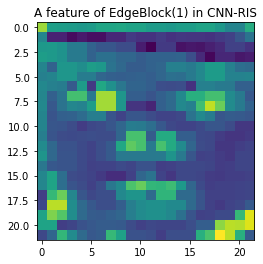

In [2]:
img = cv2.imread('train_09123.jpg')

tnet = Teacher()
tcheckpoint = torch.load('results/RAF_Teacher_False/Best_Teacher_model.t7')
tnet.load_state_dict(tcheckpoint['tnet'], strict=False)
tmean = [0.5884594, 0.45767313, 0.40865755]
tstd = [0.25717735, 0.23602168, 0.23505741]
timg = preprocess_image(img, tmean, tstd, resize_Teacher=True)

snet = CNN_RIS()
scheckpoint = torch.load('results/RAF_Student_False/PrivateTest_model.t7')
snet.load_state_dict(scheckpoint['net'], strict=False)
smean = [0.58846486, 0.45766878, 0.40865615]
sstd = [0.2516557, 0.23020789, 0.22939532]
simg = preprocess_image(img, smean, sstd, resize_Teacher=False)

with torch.no_grad():
    rb1_t, rb2_t, rb3_t, mimic_t, out_t = tnet(timg)
    rb1_s, rb2_s, rb3_s, mimic_s, out_s = snet(simg)

decoder = Decoder()
x_one, x0, x1, x_two, x2, x3, x_three, x4, x5 = decoder(rb1_s)

rb1_s = preprocess_feature(rb1_s)
print (rb1_s.shape)
plt.figure("rb1_s") # 图像窗口名称
plt.imshow(rb1_s[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("A feature of EdgeBlock(1) in CNN-RIS") # 图像题目
plt.savefig('./EdgeBlock1.jpg')
plt.show()

(24, 44, 44)


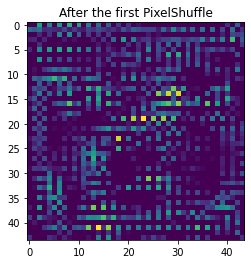

In [3]:
x0 = preprocess_feature(x0)
print (x0.shape)
plt.figure("x0") # 图像窗口名称
plt.imshow(x0[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("After the first PixelShuffle") # 图像题目
plt.savefig('./PixelShuffle1.jpg')
plt.show()

(24, 44, 44)


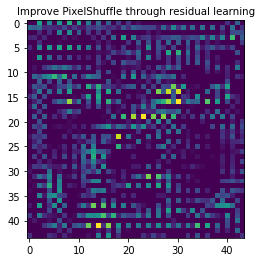

In [4]:
x1 = preprocess_feature(x1)
print (x1.shape)
plt.figure("x1") # 图像窗口名称
plt.imshow(x1[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("Improve PixelShuffle through residual learning",fontsize=10.2) # 图像题目
plt.savefig('./ResPixelShuffle1.jpg')
plt.show()

(6, 88, 88)


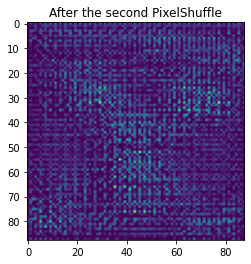

In [5]:
x2 = preprocess_feature(x2)
print (x2.shape)
plt.figure("x2") # 图像窗口名称
plt.imshow(x2[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("After the second PixelShuffle") # 图像题目
plt.savefig('./PixelShuffle2.jpg')
plt.show()

(6, 88, 88)


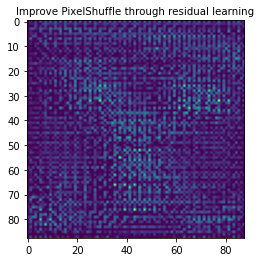

In [6]:
x3 = preprocess_feature(x3)
print (x3.shape)
plt.figure("x3") # 图像窗口名称
plt.imshow(x3[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("Improve PixelShuffle through residual learning",fontsize=10.2) # 图像题目
plt.savefig('./ResPixelShuffle2.jpg')
plt.show()

(6, 92, 92)


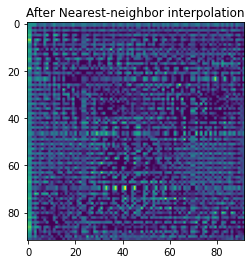

In [7]:
x_three = preprocess_feature(x_three)
print (x_three.shape)
plt.figure("x_three") # 图像窗口名称
plt.imshow(x_three[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("After Nearest-neighbor interpolation") # 图像题目
plt.savefig('./interpolation.jpg')
plt.show()

(6, 92, 92)


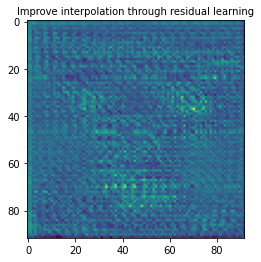

In [8]:
x4 = preprocess_feature(x4)
print (x4.shape)
plt.figure("x4") # 图像窗口名称
plt.imshow(x4[0,:,:])
plt.axis('on') # 关掉坐标轴为 off
plt.title("Improve interpolation through residual learning",fontsize=10) # 图像题目
plt.savefig('./ResInterpolation.jpg')
plt.show()